In [ ]:
from scipy.stats import bernoulli
from scipy.sparse import csr_array, coo_array
from scipy.sparse.csgraph import minimum_spanning_tree
import sparse
import numpy as np
from affinis.associations import ochiai, _spanning_forests_obs_bootstrap
from tqdm import tqdm 

from mendr.experiments import (
    load_graph, _datasets,_estimators, _metrics,_sq, _dataset_paths
)
import matplotlib.pyplot as plt
%load_ext memray

In [351]:
from scipy.stats import ecdf

def hinton_scatter(A, ax=None): 
    i,j = A.coords[1]+0.5, A.coords[0]+0.5
    ax = ax if ax is not None else plt.gca()
    
    ax.patch.set_facecolor('gray')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_aspect('equal')
    ax.set_xlim(-0.5,A.shape[1]+0.5)
    ax.set_ylim(-0.5, A.shape[0]+0.5)
    plt.gcf().canvas.draw()

    ext = ax.get_window_extent()
    base_size = ((ext.width)*(72./plt.gcf().dpi)/(A.shape[1]+2))**2
    size = np.abs(A.data)
    size = base_size*size/size.max()
    color=np.where(A.data>0, 'white', 'black')

    ax.scatter(i,j, s=size, c=color, marker='s', linewidth=0)
    ax.autoscale_view()
    ax.invert_yaxis()

    



# hinton_scatter(X.T@X)
# plt.scatter(
# plt.grid(
# plt.Axes.set_aspect(

268.9577464788733

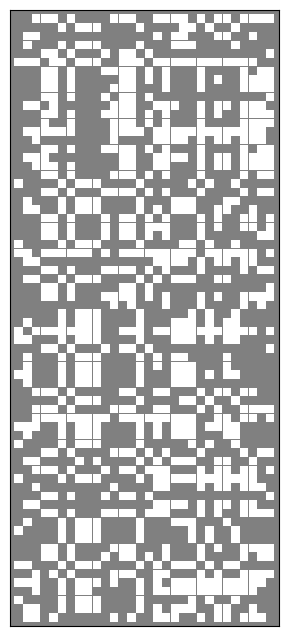

In [352]:
plt.figure(figsize=(8,8))
exp = load_graph('BL-N030S24')
X = exp.activations.to_array()
X_sp = csr_array(X.to_scipy_sparse())
hinton_scatter(X)
# plt.grid()
X.density

plt.gca().get_window_extent().width
# N = 1000
# Nx = 2000
# node_probs = np.random.rand(N)/4
# X = sparse.COO(bernoulli.rvs(node_probs, size=(Nx,N))).astype(bool)
# X.sum(axis=0).todense()/Nx, node_probs
# _datasets
# plt.scatter(X.coords[0], X.coords[1], s=1)


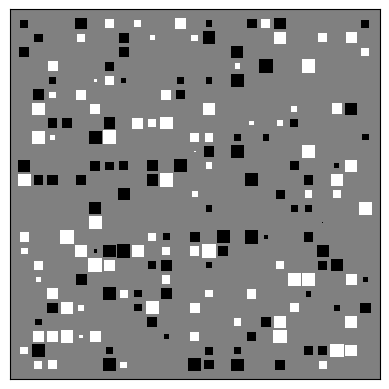

In [378]:
# hinton_scatter(X.T@X)
(sparse.random((25,25), density=0.3)
 |> (=> _-_.data.mean())
 |> hinton_scatter
)

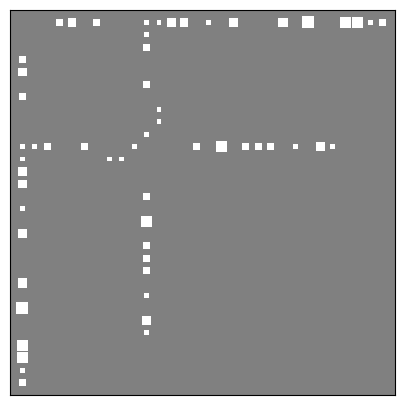

In [377]:
plt.figure(figsize=(5,5))
T = minimum_spanning_tree((X.T@X).tocsr())  |> sparse.COO |> (=> np.maximum(_,_.T))#|> (=> _/_.sum(axis=0))|>.sum(axis=0)
# plt.figure(figsize=(3,3))
# plt.scatter(T.coords[1]/T.shape[1], 1-T.coords[0]/T.shape[0], s=1)
# plt.plot(np.linspace(0,1), 1-np.linspace(0,1))
# sparse.COO.to
hinton_scatter(T)

In [4]:
# X[:,X[0].coords]
# X[:,X[1]]
# X[:,X[1].coords[0]]
# X_sp = csr_array(X.to_scipy_sparse())


def subsamp_cos(X, coords): 
    # print(X[:,coords].T, coords)
    return ((X[:,coords].T@X[:,coords]+0.5)/(np.sqrt(np.multiply.outer((cts:=X[:,coords].sum(axis=0)), cts))+1.)).todense()

def subsamp_idx(X, D,idx): 
    coords = X[idx].coords[0]
    subD = D[coords].T[coords].T
    # return subsamp_cos(X, coords) 
    return subD
# X_sp
# subtree_X = subsamp_idx$(X, -np.log(ochiai(X_sp)))..>minimum_spanning_tree
# subcos = idx->subsamp_cos(X, X[idx].coords[0])
# subcos = subsamp_idx$(X, ochiai(X_sp))

In [441]:

# %load_ext line_profiler
# list(map(subcos..>.shape, range(X.shape[0])))
def group_1by0(a):
    '''[see source](https://stackoverflow.com/a/43094244)'''
    return np.split(a[:,1], np.unique(a[:, 0], return_index=True)[1][1:])

# def _onecold(a):
#     n = len(a)
#     s = a.strides[0]
#     strided = np.lib.stride_tricks.as_strided
#     b = np.concatenate((a,a[:-1]))
#     return strided(b[1:], shape=(n-1,n), strides=(s,s))

# def combinations_without_repeat(a):
#     '''[see source](https://stackoverflow.com/a/48234170)'''
#     n = len(a)
#     out = np.empty((n,n-1,2),dtype=a.dtype)
#     out[:,:,0] = np.broadcast_to(a[:,None], (n, n-1))
#     out.shape = (n-1,n,2)
#     out[:,:,1] = _onecold(a)
#     out.shape = (-1,2)
#     return out  

def pairwise_combs_mask(a):
    '''https://stackoverflow.com/a/57567014'''
    n = len(a)
    L = n*(n-1)//2
    out = np.empty((L,2),dtype=a.dtype)
    m = ~np.tri(len(a),dtype=bool)
    out[:,0] = np.broadcast_to(a[:,None],(n,n))[m]
    out[:,1] = np.broadcast_to(a,(n,n))[m]
    return out

def sq_to_linear_triu_idx(n,i,j):
    return (n*(n-1)/2) - (n-i)*((n-i)-1)/2 + j - i - 1
def sqarr_to_linear_triu_idx(n,ij):
    i,j = ij
    return sq_to_linear_triu_idx(n,i,j)
    
def linear_to_sq_triu_idx(n,k):
    i = n - 2 - np.floor(np.sqrt(-8*k + 4*n*(n-1)-7)/2.0 - 0.5)
    j = k + i + 1 - n*(n-1)/2 + (n-i)*((n-i)-1)/2
    return i.astype(int),j.astype(int)

def nodelist_to_complete_edgelist(n,u): 
    return u |> pairwise_combs_mask |> .T |> sqarr_to_linear_triu_idx$(n)

def sparseG_to_Eidx(A):
    N = A.shape[0]
    return A.coords |> sqarr_to_linear_triu_idx$(N)

def nodes_to_tree_map(dists,nodes): 
    N = dists.shape[0]
    all_E = nodelist_to_complete_edgelist(N, nodes).astype(int)
    tree_E = (
        dists[nodes].T[nodes].T 
        |> minimum_spanning_tree 
        |> sparse.COO.from_scipy_sparse 
        |> sparseG_to_Eidx
    )
    return all_E[tree_E.astype(int)]

The memray extension is already loaded. To reload it, use:
  %reload_ext memray


In [442]:
def nodes_to_tree_degrees(dists,nodes): 
    N = dists.shape[0]
    all_E = nodelist_to_complete_edgelist(N, nodes).astype(int)
    tree_E = dists[nodes].T[nodes].T |> minimum_spanning_tree |> sparse.COO |> sparseG_to_Eidx
    return all_E[tree_E.astype(int)]

In [443]:
n_e = sq_to_linear_triu_idx(n:=X.shape[1],n-1,n)|> int
n_e

(n,n_e)

X_sp.tocoo()


<70x30 sparse array of type '<class 'numpy.int64'>'
	with 904 stored elements in COOrdinate format>

In [451]:
# sparse.COO(X.todense())
# X_nodes

In [446]:
# %%timeit
X_nodes = X.coords.T |> group_1by0
dists = -np.log(ochiai(X_sp))
subtree_X = nodes_to_tree_map$(dists)
%timeit list(parallel_map(subtree_X, X_nodes))

601 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [465]:
X.to_scipy_sparse()

<70x30 sparse matrix of type '<class 'numpy.int64'>'
	with 904 stored elements in COOrdinate format>

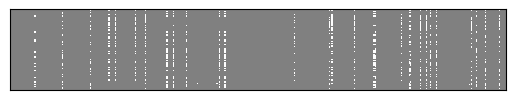

In [467]:
# %%timeit 
X_nodes = X.coords.T |> group_1by0
dists = -np.log(ochiai(X_sp))
X_edges = list(map(nodes_to_tree_map$(dists), X_nodes))
X_e = sparse.COO(coords=np.vstack(
    [np.repeat(np.arange(len(X_edges))[:,None], np.array(map(len,X_edges))),
     np.concatenate(X_edges)
    ]
), data=1, shape=(X.shape[0], X.shape[1]*(X.shape[1]-1)//2))

hinton_scatter(X_e)

In [449]:
# X.coords.T |> group_1by0 |> parallel_map$(nodelist_to_complete_edgelist$(X.shape[1])) |> .[:10]|> list
# X.coords.T |> group_1by0 |> .[0] |> pairwise_combs_mask |> .T
(
    (np.array([len(a)*[i], a]).T 
     for  i,a in (
         X_nodes|>enumerate..map$(subtree_X)
     ))
    |> list
    |> np.vstack
    

)

array([[  0,  70],
       [  0,  86],
       [  0,  92],
       ...,
       [ 69, 405],
       [ 69, 417],
       [ 69, 429]])

In [447]:
%prun -s cumtime list(map(subtree_X, X_nodes))

         59588 function calls (59238 primitive calls) in 0.100 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.100    0.100 {built-in method builtins.exec}
        1    0.000    0.000    0.100    0.100 <string>:1(<module>)
       70    0.004    0.000    0.100    0.001 <ipython-input-441-d177a913bbf8>:64(nodes_to_tree_map)
       70    0.006    0.000    0.048    0.001 _validation.py:12(validate_graph)
       70    0.001    0.000    0.024    0.000 core.py:428(from_scipy_sparse)
      140    0.002    0.000    0.015    0.000 <string>:217(tail_call_optimized_func)
      490    0.006    0.000    0.014    0.000 core.py:2978(__array_finalize__)
      140    0.001    0.000    0.013    0.000 _compressed.py:27(__init__)
       70    0.001    0.000    0.013    0.000 core.py:2260(masked_values)
       70    0.000    0.000    0.012    0.000 _base.py:407(asformat)
       70    0.001    0.000    0.012    

In [448]:
%%memray_flamegraph --native
list(map(subtree_X, X_nodes))

⠋[?25l Calculating high watermark... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━    Calculating high watermark... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   
  ?25l Processing allocation records... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--Processing allocation records... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Results saved to memray-results/tmpc2a4w81h/flamegraph.html


In [10]:
%%timeit 

_spanning_forests_obs_bootstrap(X_sp)

877 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%prun -s cumtime _spanning_forests_obs_bootstrap(X_sp)

         281189 function calls (280460 primitive calls) in 1.021 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.021    1.021 {built-in method builtins.exec}
        1    0.001    0.001    1.021    1.021 <string>:1(<module>)
        1    0.001    0.001    1.020    1.020 associations.py:233(_spanning_forests_obs_bootstrap)
        1    0.044    0.044    0.942    0.942 associations.py:240(<listcomp>)
      670    0.053    0.000    0.595    0.001 utils.py:40(_get_masked_sq)
      671    0.014    0.000    0.494    0.001 _coo.py:27(__init__)
      671    0.393    0.001    0.393    0.001 {method 'nonzero' of 'numpy.ndarray' objects}
2015/1344    0.013    0.000    0.159    0.000 _compressed.py:27(__init__)
      670    0.004    0.000    0.119    0.000 _validation.py:12(validate_graph)
      671    0.002    0.000    0.094    0.000 _base.py:407(asformat)
      670    0.006    0.000    0.091    0.00

In [12]:
%%memray_flamegraph --native

_spanning_forests_obs_bootstrap(X_sp)

⠋[?25l Calculating high watermark... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━    Calculating high watermark... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   
  ?25l Processing allocation records... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--Processing allocation records... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
Results saved to memray-results/tmp84dpwzi6/flamegraph.html


In [48]:
%%timeit

list(map(subtree_X, range(X.shape[0])))
    

8.78 s ± 203 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
